In [220]:
import numpy as np
from torch.utils.data import Dataset
import pandas as pd

label_names = ["High card", "One pair", "Two pairs", "Three of a kind", "Straight",
               "Flush", "Full house", "Four of a kind", "Straight flush", "Royal flush"]

class PokerDataset(Dataset):
    def __init__(self, path: str, one_hot: bool = False):
        self.data = pd.read_csv(path)
        self.data.columns = ["suit1", "num1", "suit2", "num2", "suit3", "num3", "suit4", "num4", "suit5", "num5", "out"]
        self.data = self.data.astype({"suit1": "category", 
                                      "suit2": "category", 
                                      "suit3": "category", 
                                      "suit4": "category", 
                                      "suit5": "category"})
        # if one_hot, one hot encode both the suit and number columns
        if one_hot:
            suit_cols = ["suit1", "suit2", "suit3", "suit4", "suit5"]
            num_cols = ["num1", "num2", "num3", "num4", "num5"]
            self.data = pd.get_dummies(self.data, columns=suit_cols + num_cols)

    def __getattr__(self, name):
        return getattr(self.data, name)
    
    def __getitem__(self, idx):
        return self.data.iloc[idx]


In [232]:
path = "poker/all-poker-hands-augmented"
train_path = path + "-train.data"
test_path = path + "-test.data"

if train_path == "poker/all-poker-hands-train.data":
    data_name = "Standard"
elif train_path == "poker/all-poker-hands-augmented-train.data":
    data_name = "Augmented"
elif train_path == "poker/all-poker-hands-perm-free-train.data":
    data_name = "Perm_Free"
elif train_path == "poker/all-poker-hands-augmented-perm-free-train.data":
    data_name = "Perm_Free_Augmented"
else:
    print ("Unknown data name")

In [ ]:
def generate_split(row_cap: int, one_hot: bool = False, seed: int = 42):
    train_data = PokerDataset(train_path, one_hot=one_hot)
    test_data = PokerDataset(test_path, one_hot=one_hot)
    train_data.data = train_data.data.sample(n=row_cap, random_state=42)
    test_data.data = test_data.data.sample(n=row_cap, random_state=42)
    X_train, y_train = train_data.drop("out", axis=1), train_data.data["out"]
    X_test, y_test = test_data.drop("out", axis=1), test_data.data["out"]
    return X_train, y_train, X_test, y_test

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
def disp_results(y_true, y_pred, title: str): 
    fig, ax = plt.subplots(figsize=(6, 6))
    # check that label_names has correct length
    label_names_len = len(np.unique(y_true))
    if len(label_names) != label_names_len:
        print ("Warning: Some labels did not appear in the training or test set.")
    unique_vals = sorted(list(np.unique(y_true)))
    new_label_names = [label_names[i] for i in unique_vals] 

    from sklearn.metrics import f1_score
    f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_true, y_pred)
    print (f"Accuracy: {acc:.4f}")
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=new_label_names, cmap=plt.cm.Blues, normalize='true', values_format='.2f', ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    # put f1 score in the bottom right corner of the plot
    plt.text(4.5, -1.5, f'Macro F1 Score: {f1:.4f}', verticalalignment='bottom', horizontalalignment='center', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
    path = f"images/{title.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    # print F1 score
    print ("F1 score:", f1)

In [ ]:

X_train, y_train, X_test, y_test = generate_split(row_cap=int(2e6), one_hot=True, seed=42)

import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=10,
    tree_method='auto', 
    enable_categorical=True 
)
xgb_model.fit(X_train, y_train)
xgb_out = xgb_model.predict(X_test)

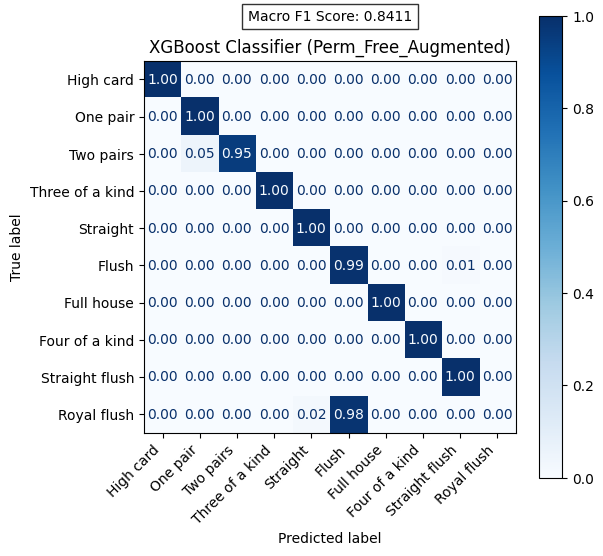

F1 score: 0.8411340081193753


In [224]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp_results(y_test, xgb_out, f"XGBoost Classifier ({data_name})")


In [225]:
X_train, y_train, X_test, y_test = generate_split(row_cap=int(2e4), one_hot=True, seed=42)
# xgb complains if a class isn't represented in the training data, so we need to work around it
missing_classes = list(set(range(10)) - set(y_train.unique()))
if len(missing_classes) > 0:
    for mc in missing_classes:
        # add one instance of the missing class to the training data
        X_train = pd.concat([X_train, X_train.iloc[[0]]], ignore_index=True)
        y_train = pd.concat([y_train, pd.Series([mc])], ignore_index=True)
print ("Generated split. ")
missing_classes = list(set(range(10)) - set(y_test.unique()))
if len(missing_classes) > 0:
    for mc in missing_classes:
        # add one instance of the missing class to the test data
        X_test = pd.concat([X_test, X_test.iloc[[0]]], ignore_index=True)
        y_test = pd.concat([y_test, pd.Series([mc])], ignore_index=True)
print ("Ensured all classes present. ")

# decision tree, random forest, gradient boost models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

print ("Training Decision tree")

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_out = dt_model.predict(X_test)

print ("Training Random forest")

rf_model = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_out = rf_model.predict(X_test)

print ("Training Gradient boosting")

gb_model = GradientBoostingClassifier(n_estimators=250, max_depth=10, random_state=42)
gb_model.fit(X_train, y_train)
gb_out = gb_model.predict(X_test)

print ("Training XGBoost")

# for a fairer comparison, xgb with less training data 
xgb_model_light = xgb.XGBClassifier(n_estimators=250, max_depth=10,tree_method='auto', enable_categorical=True)
xgb_model_light.fit(X_train, y_train)
xgb_light_out = xgb_model_light.predict(X_test)



Generated split. 
Ensured all classes present. 
Training Decision tree
Training Random forest
Training Gradient boosting
Training XGBoost


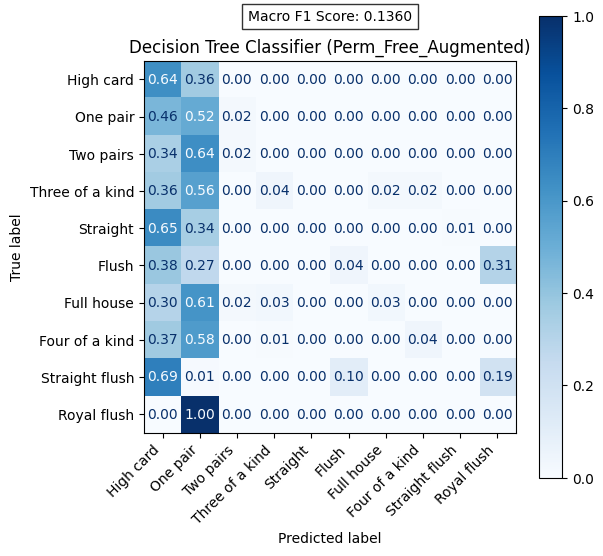

F1 score: 0.13603134870916408


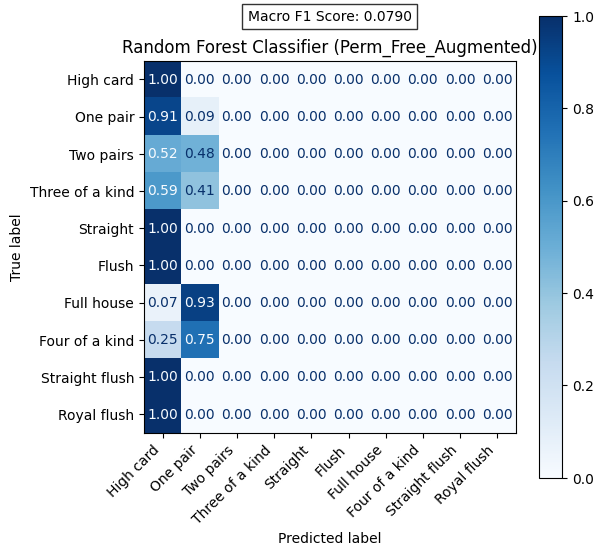

F1 score: 0.07896557661468331


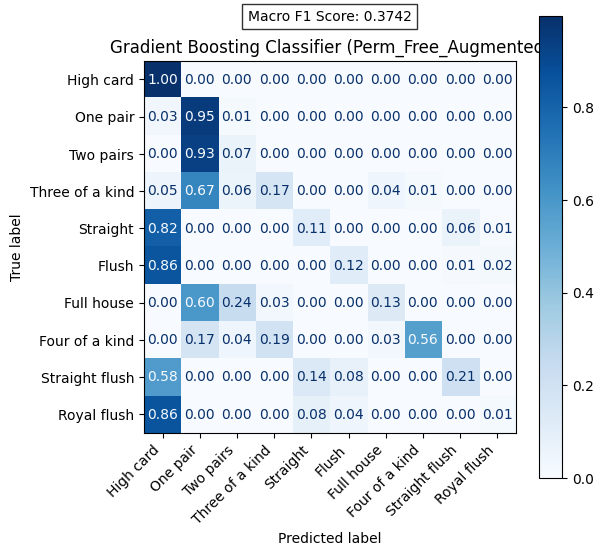

F1 score: 0.3742349545868801


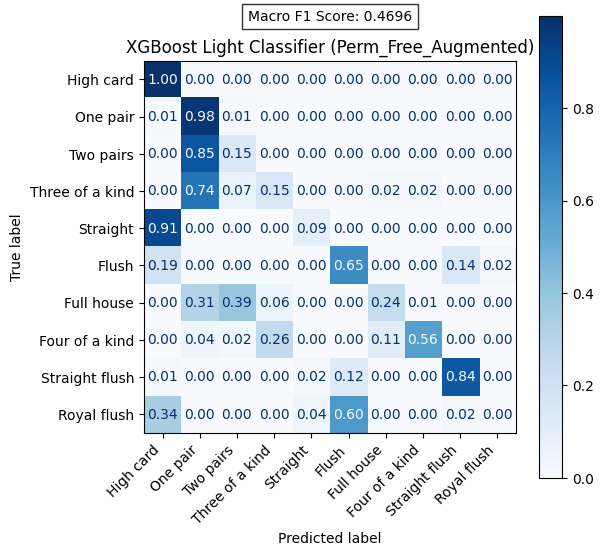

F1 score: 0.46963887038227436


In [226]:
disp_results(y_test, dt_out, f"Decision Tree Classifier ({data_name})")
disp_results(y_test, rf_out, f"Random Forest Classifier ({data_name})")
disp_results(y_test, gb_out, f"Gradient Boosting Classifier ({data_name})")
disp_results(y_test, xgb_light_out, f"XGBoost Light Classifier ({data_name})")

In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class PokerClassifierNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(85, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.seq(x)



In [228]:
row_cap = int(2e6)

train_data = PokerDataset(train_path, one_hot=True)
test_data = PokerDataset(test_path, one_hot=True)
train_data.data = train_data.data.sample(n=row_cap, random_state=42)
X_train, y_train = train_data.drop("out", axis=1), train_data.data["out"]
test_data.data = test_data.data.sample(n=row_cap, random_state=42)
X_test, y_test = test_data.drop("out", axis=1), test_data.data["out"]
print (X_train.head())
print (y_train.head())
print (X_train.shape)

          suit1_1  suit1_2  suit1_3  suit1_4  suit2_1  suit2_2  suit2_3  \
3922053     False    False    False     True    False    False     True   
13694114    False    False     True    False    False     True    False   
7955706     False    False    False     True    False     True    False   
2135282     False     True    False    False    False    False     True   
4545444     False    False     True    False     True    False    False   

          suit2_4  suit3_1  suit3_2  ...  num5_4  num5_5  num5_6  num5_7  \
3922053     False    False    False  ...   False   False   False   False   
13694114    False     True    False  ...   False   False   False   False   
7955706     False    False    False  ...   False   False   False   False   
2135282     False    False     True  ...   False   False   False   False   
4545444     False    False    False  ...   False   False    True   False   

          num5_8  num5_9  num5_10  num5_11  num5_12  num5_13  
3922053    False   False    F

In [229]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
pokerNet = PokerClassifierNN().to(device)

# hyperparameters
epochs = 3
lr = 0.004
batch_size = 64
optimizer = torch.optim.Adam(pokerNet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [230]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

def train(dataloader, model, loss_fn, optimizer): 
    avg_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(dataloader)
    print (f"Avg train loss: {avg_loss}")

for epoch in tqdm(range(epochs)):
    train(train_dataloader, pokerNet, criterion, optimizer)

 33%|███▎      | 1/3 [01:46<03:32, 106.34s/it]

Avg train loss: 0.2597705701765269


 67%|██████▋   | 2/3 [03:33<01:46, 106.85s/it]

Avg train loss: 0.09471980234104395


100%|██████████| 3/3 [05:19<00:00, 106.60s/it]

Avg train loss: 0.0801287832929343


Test Accuracy: 0.9679885


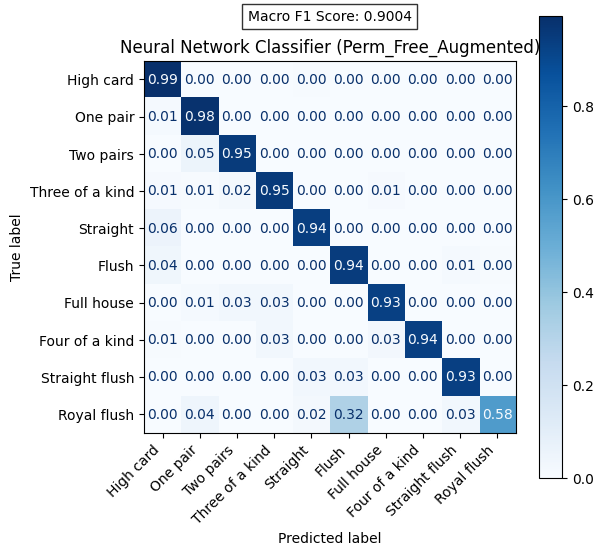

F1 score: 0.9004125575861821


0.9679885

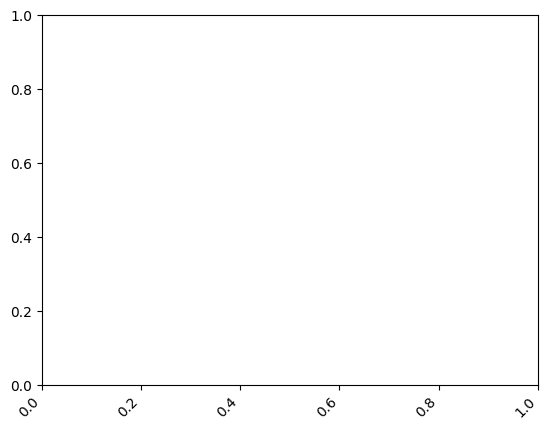

In [231]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test(dataloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        total_out = []
        for X, y in dataloader:
            outputs = model(X)
            total_out.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    acc = correct / total
    print(f"Test Accuracy: {acc}")
    disp_results(y_test, total_out, f"Neural Network Classifier ({data_name})")

    plt.xticks(rotation=45, ha='right')
    return acc

test(test_dataloader, pokerNet)